In [1]:
import torch
import torch.nn.functional as F
import nibabel as nib
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader, random_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

/home/sailesh/miniconda3/envs/rohit_mini/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sailesh/miniconda3/envs/rohit_mini/lib/python3.11/site-packages/albumentations/check_version.py:107: UserWarning: Error fetching version info <urlopen error _ssl.c:989: The handshake operation timed out>
  data = fetch_version_info()


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
# -------------------------------------------
# Dice coefficient computation for multilabel segmentation
def dice_coefficient(outputs, targets, threshold=0.5, smooth=1e-8):
    # Apply sigmoid to obtain probabilities and threshold to get binary predictions.
    probs = torch.sigmoid(outputs)
    preds = (probs > threshold).float()
    # Compute dice per channel: shape (B, C)
    intersection = (preds * targets).sum(dim=(2, 3))
    union = preds.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
    dice = (2 * intersection + smooth) / (union + smooth)
    return dice.mean()

# -------------------------------------------
# Pixel accuracy computation
def pixel_accuracy(outputs, targets, threshold=0.5):
    probs = torch.sigmoid(outputs)
    preds = (probs > threshold).float()
    correct = (preds == targets).float().sum()
    total = torch.numel(preds)
    return correct / total


In [4]:

# -------------------------------------------
# Define Dataset Class
class CAMUSDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_files = sorted(os.listdir(img_dir))
        self.mask_files = sorted(os.listdir(mask_dir))
   
    def __len__(self):
        return len(self.image_files)
   
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])
       
        # Load the image and mask from the .nii.gz files
        image = nib.load(img_path).get_fdata()
        mask = nib.load(mask_path).get_fdata()
       
        # Expand dims for image so that its shape becomes (H, W, 1)
        image = np.expand_dims(image, axis=-1)
        # For the mask, assume its values are 0 (background), 1, 2, or 3 (foreground classes)
        mask = mask.astype(np.int64)
       
        # Apply transformations (these are applied to both image and mask)
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]
        else:
            image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
       
        # Ensure mask is a NumPy array with shape (H, W)
        if isinstance(mask, torch.Tensor):
            if mask.ndim == 3 and mask.shape[-1] == 1:
                mask = mask.squeeze(-1)
            mask = mask.cpu().numpy()
        elif isinstance(mask, np.ndarray):
            if mask.ndim == 3 and mask.shape[-1] == 1:
                mask = np.squeeze(mask, axis=-1)
       
        # Convert the mask to one-hot encoding for the three foreground classes.
        # Mapping: pixel value 1 -> channel 0, 2 -> channel 1, 3 -> channel 2.
        H, W = mask.shape
        one_hot = np.zeros((H, W, 3), dtype=np.float32)
        for c in [1, 2, 3]:
            one_hot[:, :, c - 1] = (mask == c).astype(np.float32)
        # Transpose to (C, H, W)
        one_hot = np.transpose(one_hot, (2, 0, 1))
        mask = torch.tensor(one_hot, dtype=torch.float32)
       
        return image, mask

In [5]:
# -------------------------------------------
# Define Transformations with Data Augmentation
transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.Normalize(mean=[0.5], std=[0.5]),
    ToTensorV2()
])

In [6]:

# -------------------------------------------
# Load Dataset and split into Train and Validation sets
img_dir = "/home/sailesh/Desktop/Rohit/dataset/nii_img"
mask_dir = "/home/sailesh/Desktop/Rohit/dataset/nii_gt"
full_dataset = CAMUSDataset(img_dir=img_dir, mask_dir=mask_dir, transform=transform)
dataset_size = len(full_dataset)
val_size = int(0.1 * dataset_size)
train_size = dataset_size - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


In [7]:

# -------------------------------------------
# Define UNet Model with EfficientNet-B3 Encoder
model = smp.Unet(
    encoder_name="efficientnet-b3",
    encoder_weights="imagenet",
    in_channels=1,
    classes=3,  # Three foreground classes
    activation=None  # No activation since BCEWithLogitsLoss applies sigmoid
)
model = model.to(device)

In [8]:
model

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      1, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          10, 40, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePaddi

In [9]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary

#[batch_size, 1, height, width]
summary(model, input_size=[4, 1, 256 , 256])

Layer (type:depth-idx)                                  Output Shape              Param #
Unet                                                    [4, 3, 256, 256]          --
├─EfficientNetEncoder: 1-1                              [4, 1, 256, 256]          592,896
│    └─Conv2dStaticSamePadding: 2-1                     [4, 40, 128, 128]         360
│    │    └─ZeroPad2d: 3-1                              [4, 1, 257, 257]          --
│    └─BatchNorm2d: 2-2                                 [4, 40, 128, 128]         80
│    └─MemoryEfficientSwish: 2-3                        [4, 40, 128, 128]         --
│    └─ModuleList: 2-4                                  --                        --
│    │    └─MBConvBlock: 3-2                            [4, 24, 128, 128]         2,298
│    │    └─MBConvBlock: 3-3                            [4, 24, 128, 128]         1,206
│    │    └─MBConvBlock: 3-4                            [4, 32, 64, 64]           11,878
│    │    └─MBConvBlock: 3-5                

In [10]:
import torch
import torch.optim as optim
import numpy as np
from tqdm import tqdm

# -------------------------------------------
# Define Loss and Optimizer with L2 Regularization
criterion = torch.nn.BCEWithLogitsLoss()  # Multilabel classification loss
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# -------------------------------------------
# Training Loop with Training + Validation Metrics and tqdm
num_epochs = 50  # Increased epochs to 50

# Lists to store epoch-level metrics
train_loss_list = []
train_dice_mean_list = []
train_dice_std_list = []
train_acc_mean_list = []
train_acc_std_list = []

val_loss_list = []
val_dice_mean_list = []
val_dice_std_list = []
val_acc_mean_list = []
val_acc_std_list = []

for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    dice_train_epoch = []
    acc_train_epoch = []
    train_steps = 0
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate dice and accuracy for this batch
        dice = dice_coefficient(outputs, masks)
        acc = pixel_accuracy(outputs, masks)
        dice_train_epoch.append(dice.item())
        acc_train_epoch.append(acc.item())
        
        train_steps += 1

    epoch_train_loss = running_loss / train_steps
    epoch_train_dice_mean = np.mean(dice_train_epoch)
    epoch_train_dice_std = np.std(dice_train_epoch)
    epoch_train_acc_mean = np.mean(acc_train_epoch)
    epoch_train_acc_std = np.std(acc_train_epoch)
    
    train_loss_list.append(epoch_train_loss)
    train_dice_mean_list.append(epoch_train_dice_mean)
    train_dice_std_list.append(epoch_train_dice_std)
    train_acc_mean_list.append(epoch_train_acc_mean)
    train_acc_std_list.append(epoch_train_acc_std)
    
    # --- Validation Phase ---
    model.eval()
    running_loss = 0.0
    dice_val_epoch = []
    acc_val_epoch = []
    val_steps = 0
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            running_loss += loss.item()
            
            dice = dice_coefficient(outputs, masks)
            acc = pixel_accuracy(outputs, masks)
            dice_val_epoch.append(dice.item())
            acc_val_epoch.append(acc.item())
            
            val_steps += 1

    epoch_val_loss = running_loss / val_steps
    epoch_val_dice_mean = np.mean(dice_val_epoch)
    epoch_val_dice_std = np.std(dice_val_epoch)
    epoch_val_acc_mean = np.mean(acc_val_epoch)
    epoch_val_acc_std = np.std(acc_val_epoch)
    
    val_loss_list.append(epoch_val_loss)
    val_dice_mean_list.append(epoch_val_dice_mean)
    val_dice_std_list.append(epoch_val_dice_std)
    val_acc_mean_list.append(epoch_val_acc_mean)
    val_acc_std_list.append(epoch_val_acc_std)
    
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Train  - Loss: {epoch_train_loss:.4f}, Dice: {epoch_train_dice_mean:.4f} ± {epoch_train_dice_std:.4f}, Accuracy: {epoch_train_acc_mean:.4f} ± {epoch_train_acc_std:.4f}")
    print(f"  Val    - Loss: {epoch_val_loss:.4f}, Dice: {epoch_val_dice_mean:.4f} ± {epoch_val_dice_std:.4f}, Accuracy: {epoch_val_acc_mean:.4f} ± {epoch_val_acc_std:.4f}")

# -------------------------------------------
# Save the Final Model to a .pth file
model_save_path = "/home/sailesh/Desktop/Rohit/models/efficientn_best_nii.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Epoch 1/50 - Training:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 1/50 - Validation: 100%|██████████| 50/50 [00:02<00:00, 16.93it/s]


Epoch 1/50:
  Train  - Loss: 0.2846, Dice: 0.5010 ± 0.1172, Accuracy: 0.9212 ± 0.0999
  Val    - Loss: 0.2942, Dice: 0.3643 ± 0.0290, Accuracy: 0.8546 ± 0.0053


Epoch 2/50 - Validation: 100%|██████████| 50/50 [00:02<00:00, 17.21it/s]


Epoch 2/50:
  Train  - Loss: 0.0943, Dice: 0.8179 ± 0.0925, Accuracy: 0.9771 ± 0.0063
  Val    - Loss: 0.0811, Dice: 0.8619 ± 0.0240, Accuracy: 0.9769 ± 0.0047


Epoch 3/50 - Validation: 100%|██████████| 50/50 [00:02<00:00, 16.92it/s]


Epoch 3/50:
  Train  - Loss: 0.0624, Dice: 0.8812 ± 0.0237, Accuracy: 0.9818 ± 0.0038
  Val    - Loss: 0.0529, Dice: 0.8896 ± 0.0199, Accuracy: 0.9828 ± 0.0038


Epoch 4/50 - Validation: 100%|██████████| 50/50 [00:02<00:00, 16.80it/s]


Epoch 4/50:
  Train  - Loss: 0.0497, Dice: 0.8904 ± 0.0229, Accuracy: 0.9832 ± 0.0033
  Val    - Loss: 0.0457, Dice: 0.8956 ± 0.0198, Accuracy: 0.9839 ± 0.0035


Epoch 5/50 - Validation: 100%|██████████| 50/50 [00:03<00:00, 14.93it/s]


Epoch 5/50:
  Train  - Loss: 0.0436, Dice: 0.8954 ± 0.0207, Accuracy: 0.9840 ± 0.0029
  Val    - Loss: 0.0422, Dice: 0.8981 ± 0.0184, Accuracy: 0.9839 ± 0.0035


Epoch 6/50 - Validation: 100%|██████████| 50/50 [00:02<00:00, 17.24it/s]


Epoch 6/50:
  Train  - Loss: 0.0393, Dice: 0.9022 ± 0.0183, Accuracy: 0.9849 ± 0.0029
  Val    - Loss: 0.0401, Dice: 0.8971 ± 0.0191, Accuracy: 0.9842 ± 0.0031


Epoch 7/50 - Validation: 100%|██████████| 50/50 [00:03<00:00, 14.72it/s]


Epoch 7/50:
  Train  - Loss: 0.0364, Dice: 0.9065 ± 0.0165, Accuracy: 0.9856 ± 0.0026
  Val    - Loss: 0.0404, Dice: 0.8971 ± 0.0173, Accuracy: 0.9837 ± 0.0033


Epoch 8/50 - Validation: 100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Epoch 8/50:
  Train  - Loss: 0.0349, Dice: 0.9081 ± 0.0164, Accuracy: 0.9859 ± 0.0025
  Val    - Loss: 0.0396, Dice: 0.8962 ± 0.0198, Accuracy: 0.9839 ± 0.0033


Epoch 9/50 - Validation: 100%|██████████| 50/50 [00:04<00:00, 11.27it/s]


Epoch 9/50:
  Train  - Loss: 0.0331, Dice: 0.9118 ± 0.0154, Accuracy: 0.9865 ± 0.0023
  Val    - Loss: 0.0362, Dice: 0.9053 ± 0.0180, Accuracy: 0.9850 ± 0.0031


Epoch 10/50 - Validation: 100%|██████████| 50/50 [00:05<00:00,  8.51it/s]


Epoch 10/50:
  Train  - Loss: 0.0318, Dice: 0.9144 ± 0.0148, Accuracy: 0.9868 ± 0.0022
  Val    - Loss: 0.0355, Dice: 0.9051 ± 0.0171, Accuracy: 0.9854 ± 0.0030


Epoch 11/50 - Validation: 100%|██████████| 50/50 [00:05<00:00,  9.27it/s]


Epoch 11/50:
  Train  - Loss: 0.0307, Dice: 0.9169 ± 0.0146, Accuracy: 0.9872 ± 0.0023
  Val    - Loss: 0.0370, Dice: 0.9013 ± 0.0187, Accuracy: 0.9848 ± 0.0032


Epoch 12/50 - Validation: 100%|██████████| 50/50 [00:05<00:00,  9.00it/s]


Epoch 12/50:
  Train  - Loss: 0.0296, Dice: 0.9191 ± 0.0142, Accuracy: 0.9876 ± 0.0020
  Val    - Loss: 0.0351, Dice: 0.9071 ± 0.0170, Accuracy: 0.9855 ± 0.0031


Epoch 13/50 - Validation: 100%|██████████| 50/50 [00:05<00:00,  9.28it/s]


Epoch 13/50:
  Train  - Loss: 0.0286, Dice: 0.9214 ± 0.0140, Accuracy: 0.9879 ± 0.0020
  Val    - Loss: 0.0368, Dice: 0.9065 ± 0.0179, Accuracy: 0.9853 ± 0.0032


Epoch 14/50 - Validation: 100%|██████████| 50/50 [00:05<00:00,  8.96it/s]


Epoch 14/50:
  Train  - Loss: 0.0279, Dice: 0.9229 ± 0.0130, Accuracy: 0.9882 ± 0.0020
  Val    - Loss: 0.0362, Dice: 0.9048 ± 0.0199, Accuracy: 0.9852 ± 0.0034


Epoch 15/50 - Validation: 100%|██████████| 50/50 [00:05<00:00,  9.65it/s]


Epoch 15/50:
  Train  - Loss: 0.0268, Dice: 0.9256 ± 0.0128, Accuracy: 0.9886 ± 0.0019
  Val    - Loss: 0.0374, Dice: 0.9037 ± 0.0205, Accuracy: 0.9848 ± 0.0037


Epoch 16/50 - Validation: 100%|██████████| 50/50 [00:05<00:00,  9.18it/s]


Epoch 16/50:
  Train  - Loss: 0.0262, Dice: 0.9269 ± 0.0123, Accuracy: 0.9888 ± 0.0018
  Val    - Loss: 0.0367, Dice: 0.9035 ± 0.0197, Accuracy: 0.9850 ± 0.0036


Epoch 17/50 - Validation: 100%|██████████| 50/50 [00:05<00:00,  9.19it/s]


Epoch 17/50:
  Train  - Loss: 0.0262, Dice: 0.9262 ± 0.0142, Accuracy: 0.9888 ± 0.0018
  Val    - Loss: 0.0359, Dice: 0.9061 ± 0.0172, Accuracy: 0.9853 ± 0.0031


Epoch 18/50 - Validation: 100%|██████████| 50/50 [00:05<00:00,  9.63it/s]


Epoch 18/50:
  Train  - Loss: 0.0252, Dice: 0.9288 ± 0.0130, Accuracy: 0.9892 ± 0.0017
  Val    - Loss: 0.0367, Dice: 0.9046 ± 0.0189, Accuracy: 0.9853 ± 0.0033


Epoch 19/50 - Validation: 100%|██████████| 50/50 [00:05<00:00,  8.91it/s]


Epoch 19/50:
  Train  - Loss: 0.0248, Dice: 0.9304 ± 0.0128, Accuracy: 0.9894 ± 0.0017
  Val    - Loss: 0.0375, Dice: 0.9063 ± 0.0201, Accuracy: 0.9854 ± 0.0034


Epoch 20/50 - Validation: 100%|██████████| 50/50 [00:05<00:00,  9.30it/s]


Epoch 20/50:
  Train  - Loss: 0.0242, Dice: 0.9319 ± 0.0116, Accuracy: 0.9896 ± 0.0016
  Val    - Loss: 0.0365, Dice: 0.9059 ± 0.0180, Accuracy: 0.9854 ± 0.0032


Epoch 21/50 - Validation: 100%|██████████| 50/50 [00:05<00:00,  9.35it/s]


Epoch 21/50:
  Train  - Loss: 0.0239, Dice: 0.9327 ± 0.0110, Accuracy: 0.9897 ± 0.0016
  Val    - Loss: 0.0358, Dice: 0.9089 ± 0.0158, Accuracy: 0.9859 ± 0.0032


Epoch 22/50 - Validation: 100%|██████████| 50/50 [00:05<00:00,  9.36it/s]


Epoch 22/50:
  Train  - Loss: 0.0235, Dice: 0.9338 ± 0.0109, Accuracy: 0.9899 ± 0.0016
  Val    - Loss: 0.0367, Dice: 0.9077 ± 0.0176, Accuracy: 0.9857 ± 0.0032


Epoch 23/50 - Validation: 100%|██████████| 50/50 [00:05<00:00,  8.66it/s]


Epoch 23/50:
  Train  - Loss: 0.0232, Dice: 0.9344 ± 0.0109, Accuracy: 0.9900 ± 0.0015
  Val    - Loss: 0.0373, Dice: 0.9080 ± 0.0191, Accuracy: 0.9856 ± 0.0037


Epoch 24/50 - Validation: 100%|██████████| 50/50 [00:05<00:00,  8.72it/s]


Epoch 24/50:
  Train  - Loss: 0.0227, Dice: 0.9355 ± 0.0126, Accuracy: 0.9902 ± 0.0015
  Val    - Loss: 0.0375, Dice: 0.9063 ± 0.0229, Accuracy: 0.9855 ± 0.0039


Epoch 25/50 - Validation: 100%|██████████| 50/50 [00:05<00:00,  8.84it/s]


Epoch 25/50:
  Train  - Loss: 0.0227, Dice: 0.9356 ± 0.0115, Accuracy: 0.9902 ± 0.0017
  Val    - Loss: 0.0370, Dice: 0.9068 ± 0.0170, Accuracy: 0.9855 ± 0.0030


Epoch 26/50 - Validation: 100%|██████████| 50/50 [00:05<00:00,  9.10it/s]


Epoch 26/50:
  Train  - Loss: 0.0222, Dice: 0.9373 ± 0.0107, Accuracy: 0.9904 ± 0.0016
  Val    - Loss: 0.0366, Dice: 0.9095 ± 0.0163, Accuracy: 0.9858 ± 0.0031


Epoch 27/50 - Validation: 100%|██████████| 50/50 [00:05<00:00,  9.25it/s]


Epoch 27/50:
  Train  - Loss: 0.0217, Dice: 0.9381 ± 0.0099, Accuracy: 0.9906 ± 0.0014
  Val    - Loss: 0.0385, Dice: 0.9049 ± 0.0204, Accuracy: 0.9854 ± 0.0034


Epoch 28/50 - Validation: 100%|██████████| 50/50 [00:05<00:00,  9.47it/s]


Epoch 28/50:
  Train  - Loss: 0.0214, Dice: 0.9393 ± 0.0103, Accuracy: 0.9907 ± 0.0015
  Val    - Loss: 0.0375, Dice: 0.9090 ± 0.0191, Accuracy: 0.9857 ± 0.0041


Epoch 29/50 - Validation: 100%|██████████| 50/50 [00:05<00:00,  8.75it/s]


Epoch 29/50:
  Train  - Loss: 0.0223, Dice: 0.9372 ± 0.0119, Accuracy: 0.9904 ± 0.0017
  Val    - Loss: 0.0363, Dice: 0.9100 ± 0.0173, Accuracy: 0.9858 ± 0.0032


Epoch 30/50 - Validation: 100%|██████████| 50/50 [00:05<00:00,  8.62it/s]


Epoch 30/50:
  Train  - Loss: 0.0212, Dice: 0.9401 ± 0.0090, Accuracy: 0.9908 ± 0.0014
  Val    - Loss: 0.0369, Dice: 0.9110 ± 0.0167, Accuracy: 0.9860 ± 0.0033


Epoch 31/50 - Validation: 100%|██████████| 50/50 [00:05<00:00,  8.56it/s]


Epoch 31/50:
  Train  - Loss: 0.0210, Dice: 0.9401 ± 0.0099, Accuracy: 0.9909 ± 0.0013
  Val    - Loss: 0.0382, Dice: 0.9101 ± 0.0177, Accuracy: 0.9859 ± 0.0034


Epoch 32/50 - Validation: 100%|██████████| 50/50 [00:05<00:00,  9.07it/s]


Epoch 32/50:
  Train  - Loss: 0.0210, Dice: 0.9404 ± 0.0099, Accuracy: 0.9909 ± 0.0015
  Val    - Loss: 0.0373, Dice: 0.9108 ± 0.0167, Accuracy: 0.9860 ± 0.0033


Epoch 33/50 - Validation: 100%|██████████| 50/50 [00:05<00:00,  8.83it/s]


Epoch 33/50:
  Train  - Loss: 0.0206, Dice: 0.9414 ± 0.0091, Accuracy: 0.9910 ± 0.0014
  Val    - Loss: 0.0375, Dice: 0.9109 ± 0.0173, Accuracy: 0.9859 ± 0.0032


Epoch 34/50 - Validation: 100%|██████████| 50/50 [00:05<00:00,  9.14it/s]


Epoch 34/50:
  Train  - Loss: 0.0202, Dice: 0.9425 ± 0.0103, Accuracy: 0.9912 ± 0.0013
  Val    - Loss: 0.0383, Dice: 0.9082 ± 0.0165, Accuracy: 0.9854 ± 0.0036


Epoch 35/50 - Validation: 100%|██████████| 50/50 [00:05<00:00,  9.15it/s]


Epoch 35/50:
  Train  - Loss: 0.0200, Dice: 0.9433 ± 0.0096, Accuracy: 0.9913 ± 0.0014
  Val    - Loss: 0.0378, Dice: 0.9095 ± 0.0156, Accuracy: 0.9857 ± 0.0031


Epoch 36/50 - Validation: 100%|██████████| 50/50 [00:05<00:00,  8.96it/s]


Epoch 36/50:
  Train  - Loss: 0.0202, Dice: 0.9425 ± 0.0097, Accuracy: 0.9912 ± 0.0014
  Val    - Loss: 0.0377, Dice: 0.9118 ± 0.0180, Accuracy: 0.9862 ± 0.0034


Epoch 37/50 - Validation: 100%|██████████| 50/50 [00:05<00:00,  9.67it/s]


Epoch 37/50:
  Train  - Loss: 0.0201, Dice: 0.9431 ± 0.0096, Accuracy: 0.9913 ± 0.0014
  Val    - Loss: 0.0411, Dice: 0.9061 ± 0.0198, Accuracy: 0.9851 ± 0.0042


Epoch 38/50 - Validation: 100%|██████████| 50/50 [00:05<00:00,  9.25it/s]


Epoch 38/50:
  Train  - Loss: 0.0200, Dice: 0.9433 ± 0.0103, Accuracy: 0.9913 ± 0.0014
  Val    - Loss: 0.0397, Dice: 0.9083 ± 0.0186, Accuracy: 0.9854 ± 0.0042


Epoch 39/50 - Validation: 100%|██████████| 50/50 [00:05<00:00,  8.59it/s]


Epoch 39/50:
  Train  - Loss: 0.0198, Dice: 0.9436 ± 0.0092, Accuracy: 0.9914 ± 0.0013
  Val    - Loss: 0.0389, Dice: 0.9102 ± 0.0157, Accuracy: 0.9859 ± 0.0031


Epoch 40/50 - Validation: 100%|██████████| 50/50 [00:05<00:00,  8.70it/s]


Epoch 40/50:
  Train  - Loss: 0.0198, Dice: 0.9437 ± 0.0100, Accuracy: 0.9914 ± 0.0015
  Val    - Loss: 0.0408, Dice: 0.9077 ± 0.0185, Accuracy: 0.9851 ± 0.0036


Epoch 41/50 - Validation: 100%|██████████| 50/50 [00:05<00:00,  9.40it/s]


Epoch 41/50:
  Train  - Loss: 0.0195, Dice: 0.9444 ± 0.0100, Accuracy: 0.9915 ± 0.0013
  Val    - Loss: 0.0404, Dice: 0.9083 ± 0.0177, Accuracy: 0.9855 ± 0.0037


Epoch 42/50 - Validation: 100%|██████████| 50/50 [00:05<00:00,  9.32it/s]


Epoch 42/50:
  Train  - Loss: 0.0192, Dice: 0.9458 ± 0.0085, Accuracy: 0.9917 ± 0.0013
  Val    - Loss: 0.0397, Dice: 0.9087 ± 0.0174, Accuracy: 0.9856 ± 0.0034


Epoch 43/50 - Validation: 100%|██████████| 50/50 [00:05<00:00,  8.74it/s]


Epoch 43/50:
  Train  - Loss: 0.0191, Dice: 0.9461 ± 0.0080, Accuracy: 0.9918 ± 0.0013
  Val    - Loss: 0.0395, Dice: 0.9098 ± 0.0175, Accuracy: 0.9858 ± 0.0035


Epoch 44/50 - Validation: 100%|██████████| 50/50 [00:05<00:00,  8.82it/s]


Epoch 44/50:
  Train  - Loss: 0.0189, Dice: 0.9463 ± 0.0085, Accuracy: 0.9918 ± 0.0012
  Val    - Loss: 0.0403, Dice: 0.9068 ± 0.0203, Accuracy: 0.9855 ± 0.0037


Epoch 45/50 - Validation: 100%|██████████| 50/50 [00:04<00:00, 10.98it/s]


Epoch 45/50:
  Train  - Loss: 0.0191, Dice: 0.9455 ± 0.0099, Accuracy: 0.9917 ± 0.0013
  Val    - Loss: 0.0404, Dice: 0.9053 ± 0.0191, Accuracy: 0.9854 ± 0.0037


Epoch 46/50 - Validation: 100%|██████████| 50/50 [00:04<00:00, 11.08it/s]


Epoch 46/50:
  Train  - Loss: 0.0188, Dice: 0.9468 ± 0.0081, Accuracy: 0.9919 ± 0.0012
  Val    - Loss: 0.0401, Dice: 0.9088 ± 0.0177, Accuracy: 0.9858 ± 0.0035


Epoch 47/50 - Validation: 100%|██████████| 50/50 [00:04<00:00, 11.38it/s]


Epoch 47/50:
  Train  - Loss: 0.0187, Dice: 0.9473 ± 0.0083, Accuracy: 0.9919 ± 0.0013
  Val    - Loss: 0.0407, Dice: 0.9064 ± 0.0203, Accuracy: 0.9855 ± 0.0038


Epoch 48/50 - Validation: 100%|██████████| 50/50 [00:04<00:00, 12.17it/s]


Epoch 48/50:
  Train  - Loss: 0.0186, Dice: 0.9469 ± 0.0104, Accuracy: 0.9919 ± 0.0013
  Val    - Loss: 0.0397, Dice: 0.9109 ± 0.0171, Accuracy: 0.9859 ± 0.0033


Epoch 49/50 - Validation: 100%|██████████| 50/50 [00:04<00:00, 10.69it/s]


Epoch 49/50:
  Train  - Loss: 0.0185, Dice: 0.9475 ± 0.0089, Accuracy: 0.9920 ± 0.0013
  Val    - Loss: 0.0408, Dice: 0.9069 ± 0.0212, Accuracy: 0.9854 ± 0.0039


Epoch 50/50 - Validation: 100%|██████████| 50/50 [00:04<00:00, 11.55it/s]


Epoch 50/50:
  Train  - Loss: 0.0183, Dice: 0.9479 ± 0.0092, Accuracy: 0.9921 ± 0.0012
  Val    - Loss: 0.0392, Dice: 0.9109 ± 0.0169, Accuracy: 0.9859 ± 0.0033
Model saved to /home/sailesh/Desktop/Rohit/models/efficientn_best_nii.pth


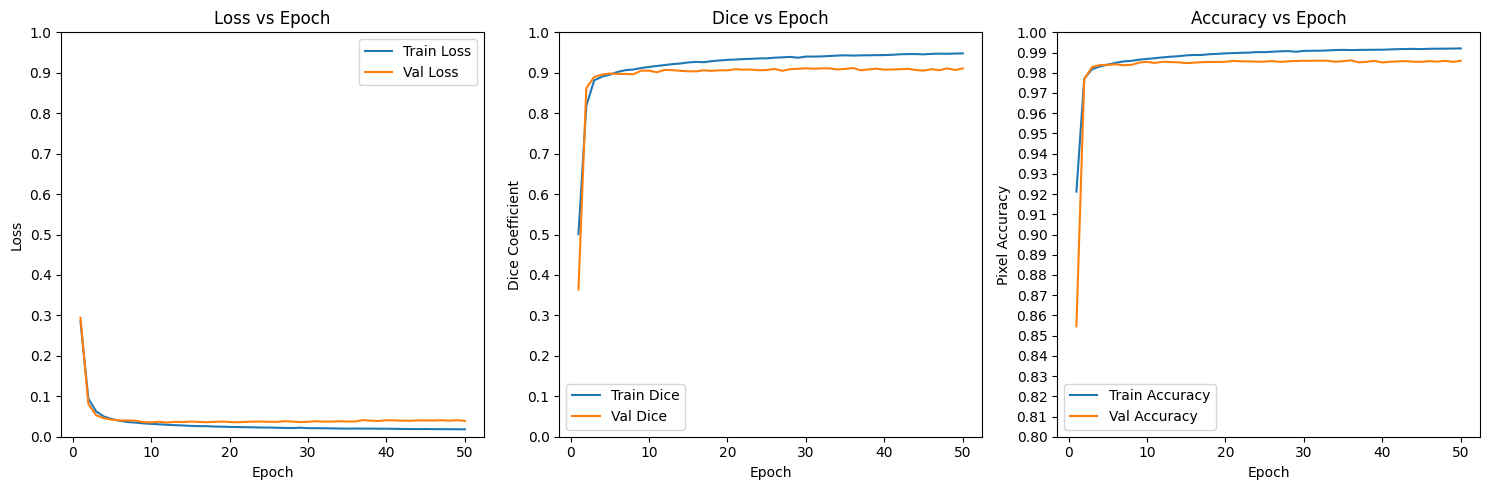

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the following variables are defined:
# num_epochs, train_loss_list, val_loss_list,
# train_dice_mean_list, val_dice_mean_list,
# train_acc_mean_list, val_acc_mean_list

epochs_range = range(1, num_epochs + 1)
plt.figure(figsize=(15, 5))

# Loss vs Epoch
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_loss_list, label="Train Loss", linestyle='-')
plt.plot(epochs_range, val_loss_list, label="Val Loss", linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.1))

# Dice vs Epoch
plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_dice_mean_list, label="Train Dice", linestyle='-')
plt.plot(epochs_range, val_dice_mean_list, label="Val Dice", linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Dice Coefficient")
plt.title("Dice vs Epoch")
plt.legend()
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.1))

# Accuracy vs Epoch (Y-axis adjusted from 0.8 to 1 with 0.01 scale)
plt.subplot(1, 3, 3)
plt.plot(epochs_range, train_acc_mean_list, label="Train Accuracy", linestyle='-')
plt.plot(epochs_range, val_acc_mean_list, label="Val Accuracy", linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Pixel Accuracy")
plt.title("Accuracy vs Epoch")
plt.legend()
plt.ylim(0.8, 1)
plt.yticks(np.arange(0.8, 1.001, 0.01))

plt.tight_layout()
plt.show()


In [1]:
import torch
import torch.nn.functional as F

def lrp_0(layer, input_activation, relevance, epsilon=1e-6):
    """
    LRP-0 rule:
      R_j <- Σ_i ( z_ji / (Σ_j z_ji + ε) ) * R_i
    where z_ji = w_ji * a_j.
    """
    # Forward pass
    z = layer(input_activation)
    
    # Compute the "distribution" factor
    s = relevance / (z + epsilon)
    
    # Backprop relevance
    c = torch.autograd.grad(z, input_activation, s, retain_graph=True)[0]
    return input_activation * c


def lrp_epsilon(layer, input_activation, relevance, epsilon=1e-6):
    """
    LRP-ε rule (epsilon rule):
      R_j <- Σ_i ( z_ji + ε·sign(z_ji) ) / (Σ_j z_ji + ε·sign(Σ_j z_ji)) * R_i
    We implement a simplified version:
      1) Forward pass to get z
      2) Add small epsilon * sign(z) to stabilize
      3) Distribute relevance
      4) Gradient w.r.t. original z
    """
    z = layer(input_activation)
    
    # Add a sign-based stabilizer
    sign_z = torch.where(z >= 0, torch.ones_like(z), -torch.ones_like(z))
    z_eps = z + epsilon * sign_z
    
    # Distribute relevance
    s = relevance / z_eps
    # Use gradient w.r.t. z (not z_eps), so we pass `z` below:
    c = torch.autograd.grad(z, input_activation, s, retain_graph=True)[0]
    return input_activation * c


def lrp_z_plus(layer, input_activation, relevance, epsilon=1e-6):
    """
    z+ (ε) rule:
      Only the positive contributions are considered in z.
      R_j <- Σ_i ( z_ji^+ / (Σ_j z_ji^+ + ε) ) * R_i
    """
    # Forward pass
    z = layer(input_activation)
    
    # Keep only positive contributions
    z_plus = torch.clamp(z, min=0)
    
    # Distribute relevance based on z+ only
    s = relevance / (z_plus + epsilon)
    
    # We take gradient wrt z_plus to zero-out negative paths
    c = torch.autograd.grad(z_plus, input_activation, s, retain_graph=True)[0]
    
    # Multiply by positive part of input as well (common variant)
    return torch.clamp(input_activation, min=0) * torch.clamp(c, min=0)


def lrp_gamma(layer, input_activation, relevance, gamma=0.5, epsilon=1e-6):
    """
    LRP-γ rule:
      Scales positive weights by (1+γ) to boost positive contributions.
    """
    # Temporarily modify layer weights for the forward pass
    W_original = layer.weight.data
    with torch.no_grad():
        W_modified = W_original.clone()
        # Scale only positive weights by (1 + gamma)
        W_modified[W_modified > 0] = W_modified[W_modified > 0] * (1.0 + gamma)
        layer.weight.data = W_modified
    
    # Forward pass with scaled weights
    z_mod = layer(input_activation)
    z_mod_plus = torch.clamp(z_mod, min=0)
    
    # Restore original weights
    layer.weight.data = W_original
    
    # Distribute relevance
    s = relevance / (z_mod_plus + epsilon)
    c = torch.autograd.grad(z_mod_plus, input_activation, s, retain_graph=True)[0]
    
    return torch.clamp(input_activation, min=0) * torch.clamp(c, min=0)


def lrp_alpha_beta(layer, input_activation, relevance, alpha=0.80, beta=0.20):
    """
    α-β rule (from your original code).
    """
    z = layer(input_activation)
    pos_z = torch.clamp(z, min=0)
    neg_z = torch.clamp(z, max=0)
    s = relevance / (pos_z + neg_z + 1e-6)
    c = torch.autograd.grad(z, input_activation, s, retain_graph=True)[0]
    return alpha * input_activation * torch.clamp(c, min=0) - beta * input_activation * torch.clamp(c, max=0)


def lrp_flat(layer, input_activation, relevance, seg_mask=None):
    """
    Flat rule + optional masking.
    """
    # 1. Forward pass (ignored, just for shape consistency).
    z = layer(input_activation)
    
    # 2. Compute total relevance (sum over output).
    B, outC, outH, outW = z.shape
    B, inC, H, W = input_activation.shape
    total_relevance = relevance.view(B, -1).sum(dim=1, keepdim=True)  # [B,1]
    
    # 3. Distribute uniformly across all input pixels.
    num_input_elements = inC * H * W
    flat_relevance = total_relevance / float(num_input_elements)
    flat_relevance = flat_relevance.view(B, 1, 1, 1).expand(B, inC, H, W)

    # 4. Optional: multiply by segmentation mask to blank out background
    if seg_mask is not None:
        # seg_mask should have shape [B, 1, H, W] or [B, inC, H, W].
        # If needed, broadcast seg_mask to match [B, inC, H, W].
        if seg_mask.shape[1] == 1 and inC > 1:
            seg_mask = seg_mask.expand(-1, inC, -1, -1)
        flat_relevance = flat_relevance * seg_mask
    
    return flat_relevance



def lrp_w_squared(layer, input_activation, relevance, epsilon=1e-6):
    """
    w² rule:
      Relevance is distributed proportionally to w².
    """
    W_original = layer.weight.data
    with torch.no_grad():
        W_modified = (W_original**2).clone()
        layer.weight.data = W_modified
    
    z_w2 = layer(input_activation)
    
    # Restore original weights
    layer.weight.data = W_original
    
    # Distribute relevance
    s = relevance / (z_w2 + epsilon)
    c = torch.autograd.grad(z_w2, input_activation, s, retain_graph=True)[0]
    
    return input_activation * c


def lrp_zB(layer, input_activation, relevance, l=0.0, h=1.0, epsilon=1e-6):
    """
    z^B rule (bounded rule).
    """
    z = layer(input_activation)
    
    W = layer.weight
    W_plus = torch.clamp(W, min=0)
    W_minus = torch.clamp(W, max=0)
    
    x_plus = torch.clamp(input_activation, min=0)
    x_minus = torch.clamp(input_activation, max=0)
    
    # zB = z - l·(x^+ * w^+) - h·(x^- * w^-)
    z_b = z
    z_b = z_b - l * F.conv2d(x_plus, W_plus, bias=None,
                             stride=layer.stride, padding=layer.padding)
    z_b = z_b - h * F.conv2d(x_minus, W_minus, bias=None,
                             stride=layer.stride, padding=layer.padding)
    
    s = relevance / (z_b + epsilon)
    c = torch.autograd.grad(z, input_activation, s, retain_graph=True)[0]
    
    return input_activation * c


In [2]:
# Suppose this is code3.py

lrp_0, lrp_epsilon, lrp_z_plus, lrp_gamma,
lrp_alpha_beta, lrp_flat, lrp_w_squared, lrp_zB

lrp_functions = {
    "LRP-0": lrp_0,
    "epsilon": lrp_epsilon,     # <-- Added here
    "z-plus": lrp_z_plus,
    "gamma": lrp_gamma,
    "alpha-beta": lrp_alpha_beta,
    "flat": lrp_flat,
    "w-squared": lrp_w_squared,
    "zB": lrp_zB
}


In [3]:
import numpy as np
import matplotlib.pyplot as plt

def overlay_seg_mask_on_image(image_np, mask_np, alpha=0.5, mask_color=(1, 0, 0)):
    """
    Overlays a binary mask on top of the original image.
      image_np: [H, W, 3], float in [0,1]
      mask_np:  [H, W], float (0 or 1) or something that can be thresholded
      alpha:    blending factor
      mask_color: (R, G, B) in [0,1]
    """
    # Ensure mask is binary or in [0,1]
    mask_bin = (mask_np > 0.5).astype(np.float32)
    
    # Convert mask to 3D color
    mask_3d = np.stack([mask_bin * c for c in mask_color], axis=-1)  # [H, W, 3]
    
    # Blend
    out = (1 - alpha) * image_np + alpha * mask_3d
    return np.clip(out, 0, 1)


def overlay_heatmap_on_image(image_np, heatmap_np, alpha=0.5, cmap='jet'):
    """
    Overlays a continuous heatmap (0..1) on top of the original image.
      image_np:   [H, W, 3], float in [0,1]
      heatmap_np: [H, W], float in [0,1]
      alpha:      blending factor
      cmap:       a matplotlib colormap name
    """
    cm = plt.get_cmap(cmap)
    colored_hm = cm(heatmap_np)[:, :, :3]  # RGBA -> take only RGB
    
    # Blend
    out = (1 - alpha) * image_np + alpha * colored_hm
    return np.clip(out, 0, 1)


In [4]:
def lrp_class_specific(relevance, class_idx):
    """
    Extract the relevance for a specific class.
    Assumes relevance shape is (B, channels, H, W) and returns (B, 1, H, W).
    """
    class_relevance = relevance[:, class_idx, :, :]
    return class_relevance.unsqueeze(1)



def apply_segmentation_mask(relevance, segmentation_output, threshold=0.5):
    """
    Apply a binary mask to the relevance.
    segmentation_output is assumed to be a probability map.
    """
    mask = segmentation_output > threshold
    return relevance * mask

/home/sailesh/miniconda3/envs/rohit_mini/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Segmentation output stats: min = 1.4239672552207594e-08 max = 0.9999760389328003 mean = 0.09786872565746307


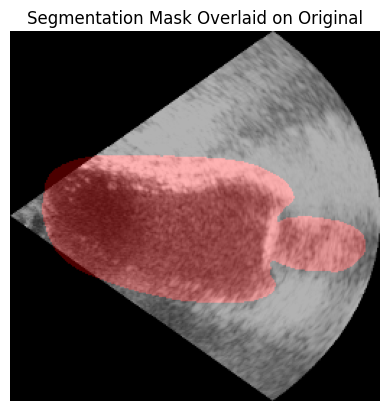


=== LRP Rule: LRP-0 ===
Relevance stats: min = -4.709295749664307 max = 3.3530712127685547 mean = -0.14532509446144104


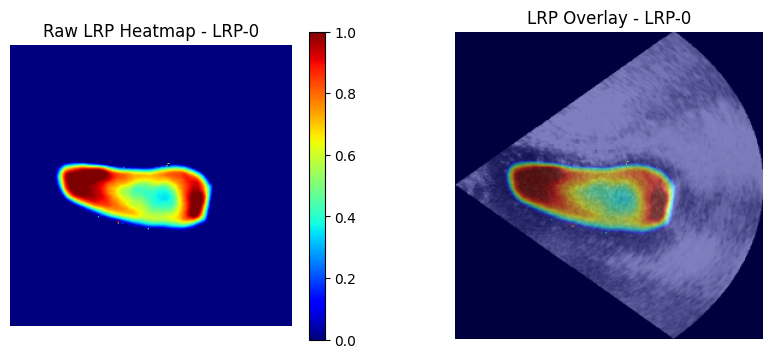


=== LRP Rule: epsilon ===
Relevance stats: min = -4.709295749664307 max = 3.353071928024292 mean = -0.14532509446144104


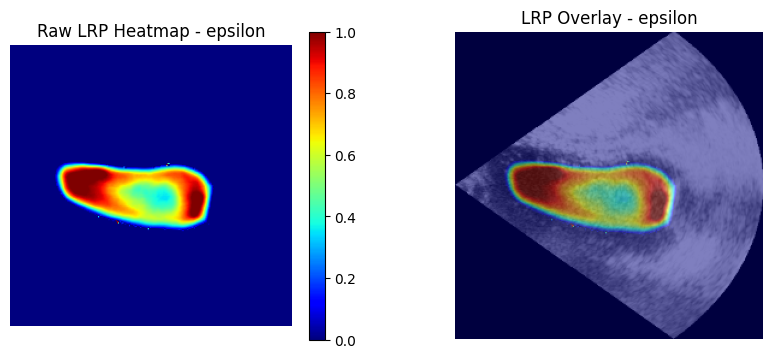


=== LRP Rule: z-plus ===
Relevance stats: min = 0.0 max = 4.904176712036133 mean = 0.05379144847393036


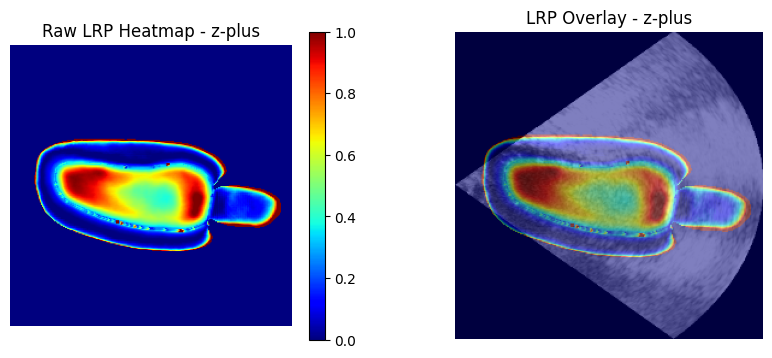


=== LRP Rule: gamma ===
Relevance stats: min = 0.0 max = 123.62173461914062 mean = 0.05494990944862366


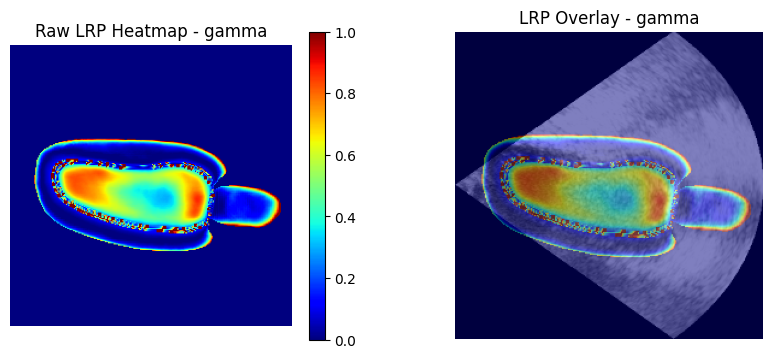


=== LRP Rule: alpha-beta ===
Relevance stats: min = 0.0 max = 4.459563732147217 mean = 0.13140982389450073


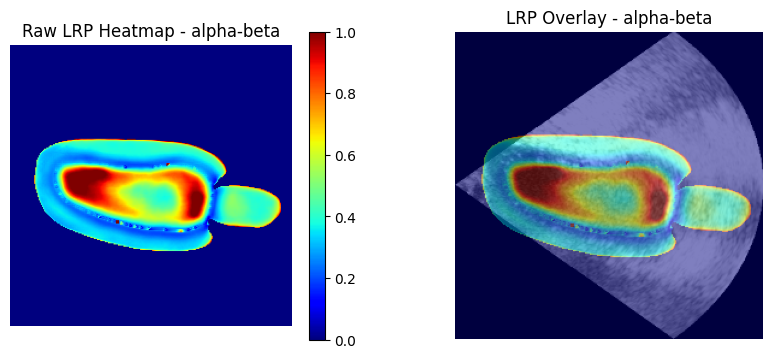


=== LRP Rule: flat ===
Relevance stats: min = -0.521061360836029 max = 0.0 mean = -0.13085369765758514


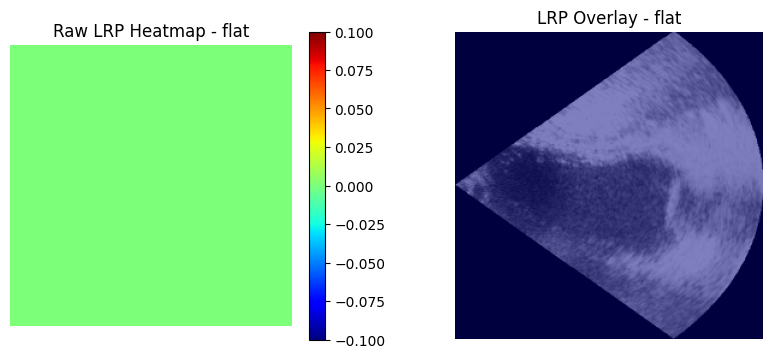


=== LRP Rule: w-squared ===
Relevance stats: min = -2.581235647201538 max = 5.555010795593262 mean = 0.1843963861465454


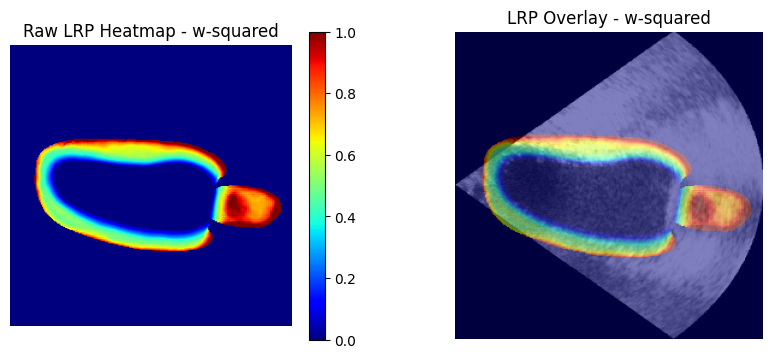


=== LRP Rule: zB ===
Relevance stats: min = -4.709295749664307 max = 3.3530712127685547 mean = -0.14532509446144104


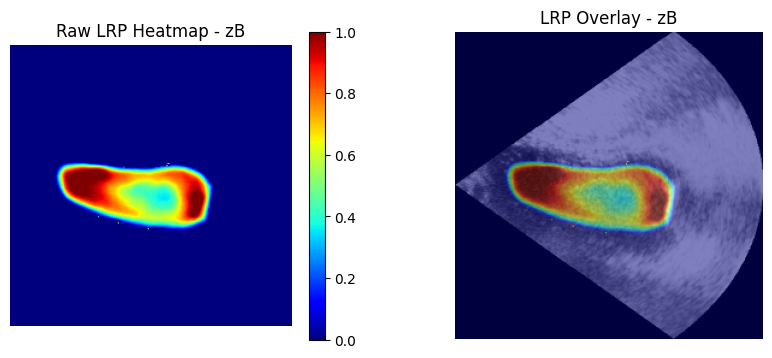

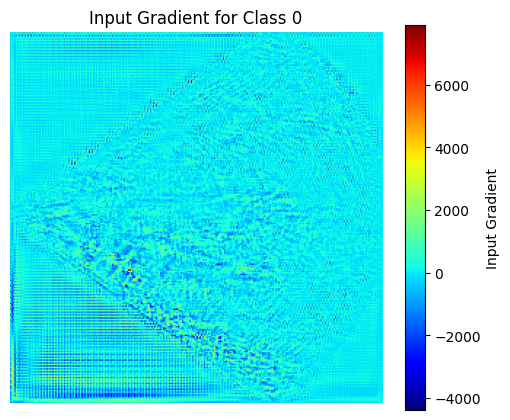

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import cv2  # For image resizing
import segmentation_models_pytorch as smp

# ----------------------------
# Helper Function to Load .nii.gz Image
# ----------------------------
def load_nii_image(image_path, target_size=(256, 256)):
    """
    Loads a 2D .nii.gz image, normalizes it, resizes it,
    and converts it to a torch tensor of shape [1, 1, H, W].
    
    Parameters:
        image_path (str): Path to the .nii.gz image.
        target_size (tuple): Desired output size as (width, height).
    
    Returns:
        torch.Tensor: The processed image tensor.
    """
    nii = nib.load(image_path)
    img_data = nii.get_fdata()
    
    # If the image is 3D, handle singleton dimensions or choose the middle slice.
    if img_data.ndim == 3:
        if img_data.shape[2] == 1:
            img_data = np.squeeze(img_data, axis=2)
        else:
            slice_index = img_data.shape[2] // 2
            img_data = img_data[:, :, slice_index]
    
    # Normalize to [0, 1]
    img_min, img_max = img_data.min(), img_data.max()
    if img_max - img_min > 0:
        img_data = (img_data - img_min) / (img_max - img_min)
    else:
        img_data = img_data - img_min
        
    # Resize using cv2 (target_size provided as (width, height))
    new_W, new_H = target_size
    resized = cv2.resize(img_data.astype(np.float32), (new_W, new_H))
    
    # Add channel dimension for a single-channel image: [1, H, W]
    resized = np.expand_dims(resized, axis=0)
    # Add batch dimension: [1, 1, H, W]
    resized = np.expand_dims(resized, axis=0)
    
    return torch.tensor(resized, dtype=torch.float32)

# ----------------------------
# Main Function
# ----------------------------
def main():
    # 1. Setup & Model Loading
    model_path = r"/home/sailesh/Desktop/Rohit/models/efficientn_best_nii.pth"
    image_path = r"/home/sailesh/Desktop/Rohit/dataset/nii_img/patient0001_2CH_ED.nii.gz"
    
    # Define UNet Model with EfficientNet-B3 Encoder
    model = smp.Unet(
        encoder_name="efficientnet-b3",
        encoder_weights="imagenet",
        in_channels=1,
        classes=3,  # Three foreground classes
        activation=None  # No activation; BCEWithLogitsLoss applies sigmoid
    )
    
    model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
    model.eval()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Load image (shape: [1, 1, H, W])
    image = load_nii_image(image_path, target_size=(256, 256)).to(device)
    image.requires_grad = True
    
    # ---- Modified Forward Pass ----
    # Instead of calling model(image) directly, we manually call the encoder,
    # decoder, and then the segmentation head.
    encoder_features = model.encoder(image)
    decoder_output = model.decoder(*encoder_features)
    output = model.segmentation_head(decoder_output)  # Final output: [1, 3, H, W]
    # ---------------------------------
    
    segmentation_output = torch.sigmoid(output)
    
    print("Segmentation output stats:",
          "min =", segmentation_output.min().item(),
          "max =", segmentation_output.max().item(),
          "mean =", segmentation_output.mean().item())
    
    # Convert the original image for visualization.
    # Replicate the single channel to form an RGB image.
    orig_img_np = image[0, 0].detach().cpu().numpy()  # [H, W]
    orig_img_np = np.stack([orig_img_np]*3, axis=-1)     # [H, W, 3]
    orig_img_np = np.clip(orig_img_np, 0, 1)
    
    # 2. Visualize Segmentation Mask Overlay
    # (Assumes overlay_seg_mask_on_image is defined elsewhere)
    seg_mask = (segmentation_output.mean(dim=1, keepdim=True) > 0.3).float()
    seg_mask_np = seg_mask[0, 0].detach().cpu().numpy()
    overlaid_seg = overlay_seg_mask_on_image(orig_img_np, seg_mask_np, alpha=0.3, mask_color=(1, 0, 0))
    
    plt.figure()
    plt.imshow(overlaid_seg)
    plt.title("Segmentation Mask Overlaid on Original")
    plt.axis("off")
    plt.show()
    
    # 3. Run Each LRP Rule and Visualize Results (applied only to the final output layer)
    class_idx = 0  # Choose the output channel (class) to analyze

    # Extract the final convolution layer from the segmentation head.
    # (Assuming model.segmentation_head is a Sequential and its first element is a Conv2d)
    final_conv = model.segmentation_head[0]

    for rule_name, lrp_fn in lrp_functions.items():
        print(f"\n=== LRP Rule: {rule_name} ===")
        # Create a clone of the final output and extract relevance for the specified class
        relevance = output.detach().clone()  # [B, 3, H, W]
        relevance = lrp_class_specific(relevance, class_idx)  # [B, 1, H, W]
        
        # Apply LRP to the final output layer.
        # Pass the activation that goes into the final convolution (decoder_output) as input.
        if rule_name == "flat":
            relevance = lrp_fn(final_conv, decoder_output, relevance, seg_mask=seg_mask)
        else:
            relevance = lrp_fn(final_conv, decoder_output, relevance)
        
        # If multiple channels exist, average them.
        if relevance.shape[1] > 1:
            relevance = relevance.mean(dim=1, keepdim=True)
        
        # Optionally apply the segmentation mask to the relevance.
        relevance = apply_segmentation_mask(relevance, seg_mask, threshold=0.3)
        print("Relevance stats:", 
              "min =", relevance.min().item(),
              "max =", relevance.max().item(),
              "mean =", relevance.mean().item())
        
        # Normalize and prepare the heatmap.
        heatmap = relevance.detach().squeeze().cpu().numpy()
        p99 = np.percentile(heatmap, 99)
        heatmap = np.clip(heatmap, 0, p99)
        hm_min, hm_max = heatmap.min(), heatmap.max()
        if hm_max > hm_min:
            heatmap = (heatmap - hm_min) / (hm_max - hm_min)
        else:
            heatmap = np.zeros_like(heatmap)
        
        overlaid_hm = overlay_heatmap_on_image(orig_img_np, heatmap, alpha=0.5, cmap='jet')
        
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(heatmap, cmap='jet')
        plt.colorbar()
        plt.title(f"Raw LRP Heatmap - {rule_name}")
        plt.axis("off")
        
        plt.subplot(1, 2, 2)
        plt.imshow(overlaid_hm)
        plt.title(f"LRP Overlay - {rule_name}")
        plt.axis("off")
        plt.show()
    
    # 4. (Optional) Visualize Input Gradient
    model.zero_grad()
    output[0, class_idx].sum().backward(retain_graph=True)
    grad = image.grad.data[0, 0].cpu().numpy()
    
    plt.figure(figsize=(6, 5))
    plt.imshow(grad, cmap='jet')
    plt.colorbar(label="Input Gradient")
    plt.title(f"Input Gradient for Class {class_idx}")
    plt.axis("off")
    plt.show()
    
if __name__ == "__main__":
    main()


Segmentation output stats: min = 1.4239672552207594e-08 max = 0.9999760389328003 mean = 0.09786872565746307


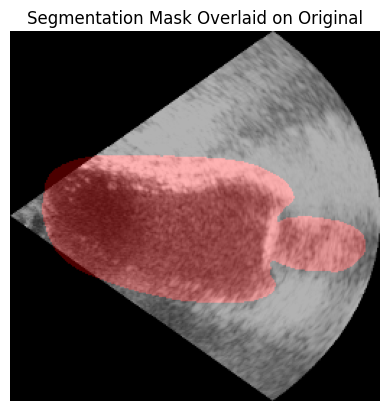


=== LRP Rule: LRP-0 ===
Relevance stats: min = -4.24223518371582 max = 2.7623822689056396 mean = -0.04988839477300644


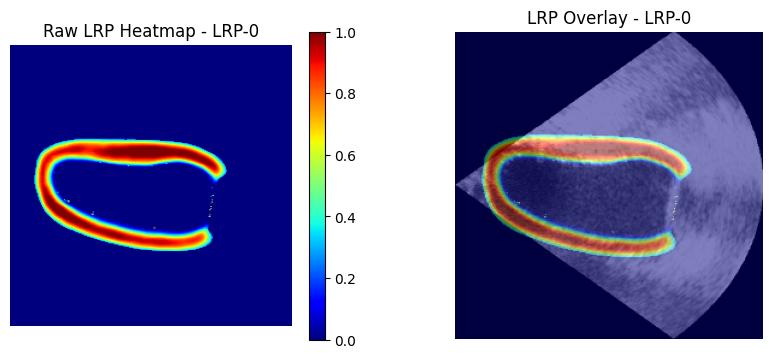


=== LRP Rule: epsilon ===
Relevance stats: min = -4.242232322692871 max = 2.762377977371216 mean = -0.04988839104771614


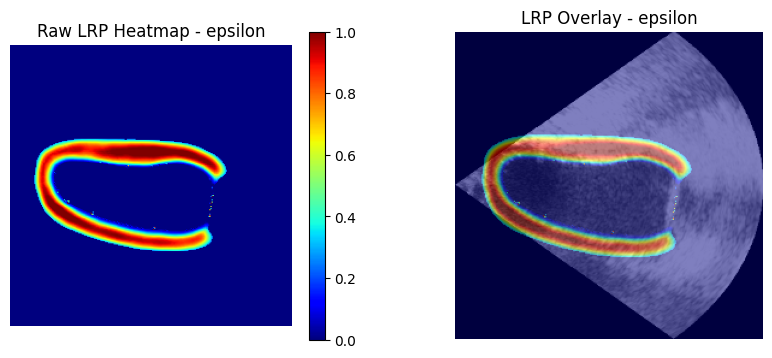


=== LRP Rule: z-plus ===
Relevance stats: min = 0.0 max = 3.821462631225586 mean = 0.05895882099866867


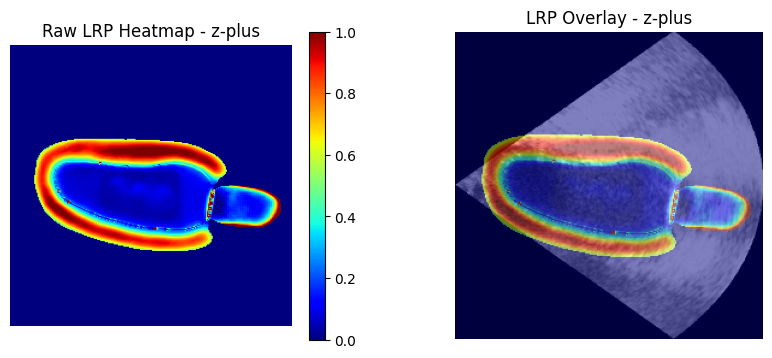


=== LRP Rule: gamma ===
Relevance stats: min = 0.0 max = 139.5670928955078 mean = 0.06145082041621208


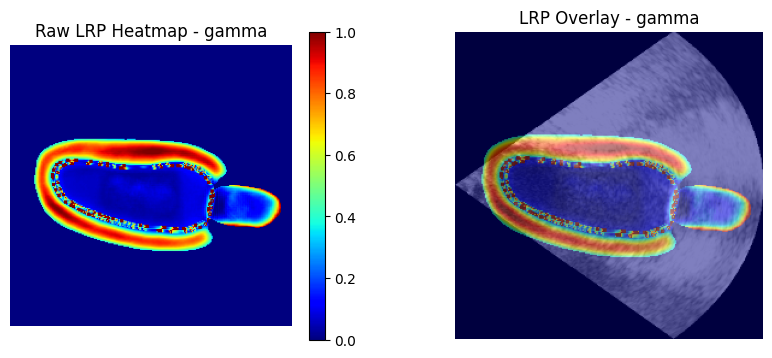


=== LRP Rule: alpha-beta ===
Relevance stats: min = 0.0 max = 4.059304237365723 mean = 0.1427907943725586


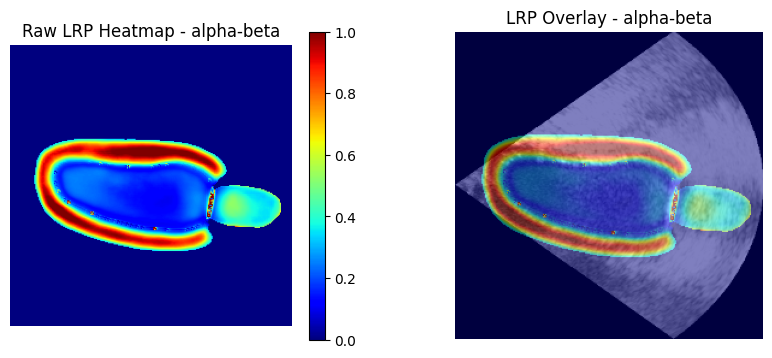


=== LRP Rule: flat ===
Relevance stats: min = -0.35800790786743164 max = 0.0 mean = -0.0899062231183052


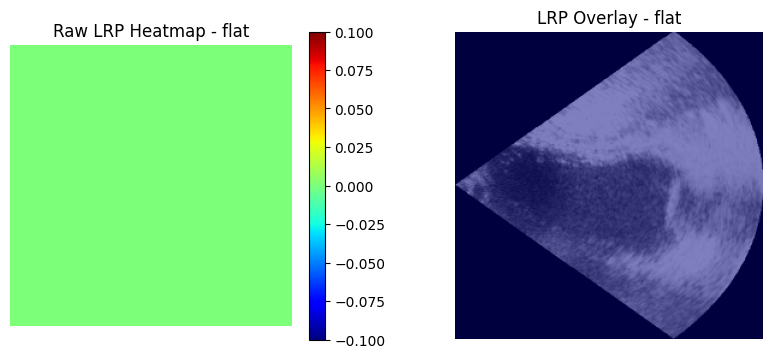


=== LRP Rule: w-squared ===
Relevance stats: min = -2.1415929794311523 max = 5.220392227172852 mean = 0.1266920566558838


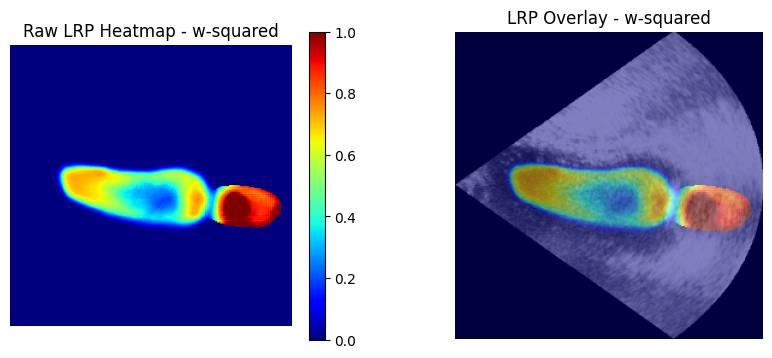


=== LRP Rule: zB ===
Relevance stats: min = -4.24223518371582 max = 2.7623822689056396 mean = -0.04988839477300644


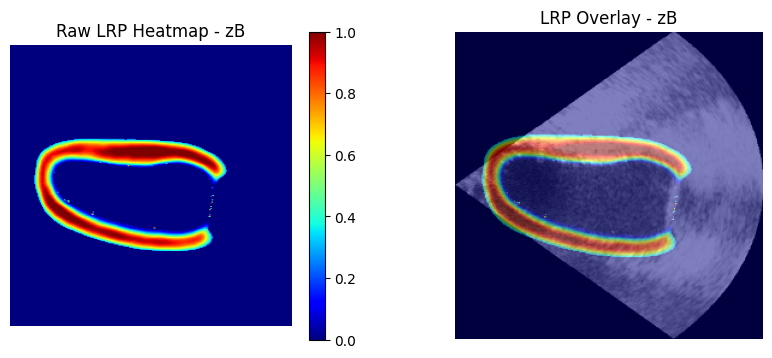

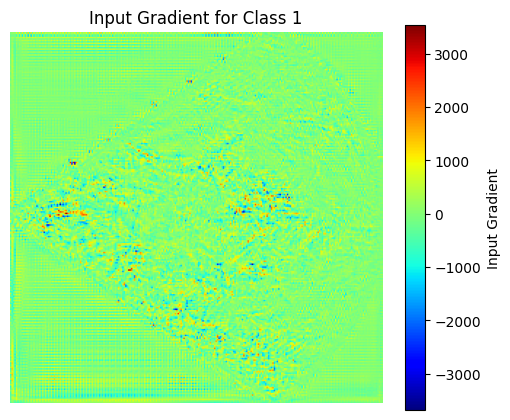

In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import cv2  # For image resizing
import segmentation_models_pytorch as smp

# ----------------------------
# Helper Function to Load .nii.gz Image
# ----------------------------
def load_nii_image(image_path, target_size=(256, 256)):
    """
    Loads a 2D .nii.gz image, normalizes it, resizes it,
    and converts it to a torch tensor of shape [1, 1, H, W].
    
    Parameters:
        image_path (str): Path to the .nii.gz image.
        target_size (tuple): Desired output size as (width, height).
    
    Returns:
        torch.Tensor: The processed image tensor.
    """
    nii = nib.load(image_path)
    img_data = nii.get_fdata()
    
    # If the image is 3D, handle singleton dimensions or choose the middle slice.
    if img_data.ndim == 3:
        if img_data.shape[2] == 1:
            img_data = np.squeeze(img_data, axis=2)
        else:
            slice_index = img_data.shape[2] // 2
            img_data = img_data[:, :, slice_index]
    
    # Normalize to [0, 1]
    img_min, img_max = img_data.min(), img_data.max()
    if img_max - img_min > 0:
        img_data = (img_data - img_min) / (img_max - img_min)
    else:
        img_data = img_data - img_min
        
    # Resize using cv2 (target_size provided as (width, height))
    new_W, new_H = target_size
    resized = cv2.resize(img_data.astype(np.float32), (new_W, new_H))
    
    # Add channel dimension for a single-channel image: [1, H, W]
    resized = np.expand_dims(resized, axis=0)
    # Add batch dimension: [1, 1, H, W]
    resized = np.expand_dims(resized, axis=0)
    
    return torch.tensor(resized, dtype=torch.float32)

# ----------------------------
# Main Function
# ----------------------------
def main():
    # 1. Setup & Model Loading
    model_path = r"/home/sailesh/Desktop/Rohit/models/efficientn_best_nii.pth"
    image_path = r"/home/sailesh/Desktop/Rohit/dataset/nii_img/patient0001_2CH_ED.nii.gz"
    
    # Define UNet Model with EfficientNet-B3 Encoder
    model = smp.Unet(
        encoder_name="efficientnet-b3",
        encoder_weights="imagenet",
        in_channels=1,
        classes=3,  # Three foreground classes
        activation=None  # No activation; BCEWithLogitsLoss applies sigmoid
    )
    
    model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
    model.eval()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Load image (shape: [1, 1, H, W])
    image = load_nii_image(image_path, target_size=(256, 256)).to(device)
    image.requires_grad = True
    
    # ---- Modified Forward Pass ----
    # Instead of calling model(image) directly, we manually call the encoder,
    # decoder, and then the segmentation head.
    encoder_features = model.encoder(image)
    decoder_output = model.decoder(*encoder_features)
    output = model.segmentation_head(decoder_output)  # Final output: [1, 3, H, W]
    # ---------------------------------
    
    segmentation_output = torch.sigmoid(output)
    
    print("Segmentation output stats:",
          "min =", segmentation_output.min().item(),
          "max =", segmentation_output.max().item(),
          "mean =", segmentation_output.mean().item())
    
    # Convert the original image for visualization.
    # Replicate the single channel to form an RGB image.
    orig_img_np = image[0, 0].detach().cpu().numpy()  # [H, W]
    orig_img_np = np.stack([orig_img_np]*3, axis=-1)     # [H, W, 3]
    orig_img_np = np.clip(orig_img_np, 0, 1)
    
    # 2. Visualize Segmentation Mask Overlay
    # (Assumes overlay_seg_mask_on_image is defined elsewhere)
    seg_mask = (segmentation_output.mean(dim=1, keepdim=True) > 0.3).float()
    seg_mask_np = seg_mask[0, 0].detach().cpu().numpy()
    overlaid_seg = overlay_seg_mask_on_image(orig_img_np, seg_mask_np, alpha=0.3, mask_color=(1, 0, 0))
    
    plt.figure()
    plt.imshow(overlaid_seg)
    plt.title("Segmentation Mask Overlaid on Original")
    plt.axis("off")
    plt.show()
    
    # 3. Run Each LRP Rule and Visualize Results (applied only to the final output layer)
    class_idx = 1  # Choose the output channel (class) to analyze

    # Extract the final convolution layer from the segmentation head.
    # (Assuming model.segmentation_head is a Sequential and its first element is a Conv2d)
    final_conv = model.segmentation_head[0]

    for rule_name, lrp_fn in lrp_functions.items():
        print(f"\n=== LRP Rule: {rule_name} ===")
        # Create a clone of the final output and extract relevance for the specified class
        relevance = output.detach().clone()  # [B, 3, H, W]
        relevance = lrp_class_specific(relevance, class_idx)  # [B, 1, H, W]
        
        # Apply LRP to the final output layer.
        # Pass the activation that goes into the final convolution (decoder_output) as input.
        if rule_name == "flat":
            relevance = lrp_fn(final_conv, decoder_output, relevance, seg_mask=seg_mask)
        else:
            relevance = lrp_fn(final_conv, decoder_output, relevance)
        
        # If multiple channels exist, average them.
        if relevance.shape[1] > 1:
            relevance = relevance.mean(dim=1, keepdim=True)
        
        # Optionally apply the segmentation mask to the relevance.
        relevance = apply_segmentation_mask(relevance, seg_mask, threshold=0.3)
        print("Relevance stats:", 
              "min =", relevance.min().item(),
              "max =", relevance.max().item(),
              "mean =", relevance.mean().item())
        
        # Normalize and prepare the heatmap.
        heatmap = relevance.detach().squeeze().cpu().numpy()
        p99 = np.percentile(heatmap, 99)
        heatmap = np.clip(heatmap, 0, p99)
        hm_min, hm_max = heatmap.min(), heatmap.max()
        if hm_max > hm_min:
            heatmap = (heatmap - hm_min) / (hm_max - hm_min)
        else:
            heatmap = np.zeros_like(heatmap)
        
        overlaid_hm = overlay_heatmap_on_image(orig_img_np, heatmap, alpha=0.5, cmap='jet')
        
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(heatmap, cmap='jet')
        plt.colorbar()
        plt.title(f"Raw LRP Heatmap - {rule_name}")
        plt.axis("off")
        
        plt.subplot(1, 2, 2)
        plt.imshow(overlaid_hm)
        plt.title(f"LRP Overlay - {rule_name}")
        plt.axis("off")
        plt.show()
    
    # 4. (Optional) Visualize Input Gradient
    model.zero_grad()
    output[0, class_idx].sum().backward(retain_graph=True)
    grad = image.grad.data[0, 0].cpu().numpy()
    
    plt.figure(figsize=(6, 5))
    plt.imshow(grad, cmap='jet')
    plt.colorbar(label="Input Gradient")
    plt.title(f"Input Gradient for Class {class_idx}")
    plt.axis("off")
    plt.show()
    
if __name__ == "__main__":
    main()

Segmentation output stats: min = 1.4239672552207594e-08 max = 0.9999760389328003 mean = 0.09786872565746307


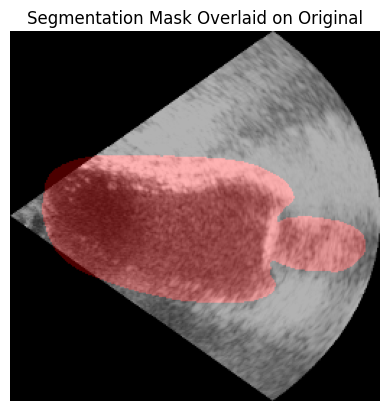


=== LRP Rule: LRP-0 ===
Relevance stats: min = -187.7501678466797 max = 240.22142028808594 mean = -0.380302369594574


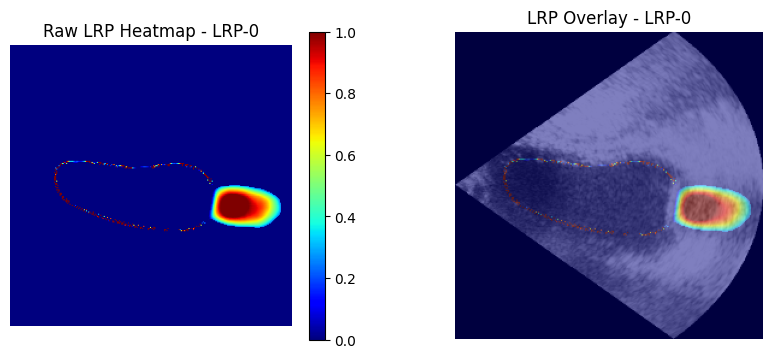


=== LRP Rule: epsilon ===
Relevance stats: min = -187.75009155273438 max = 240.22134399414062 mean = -0.3803028464317322


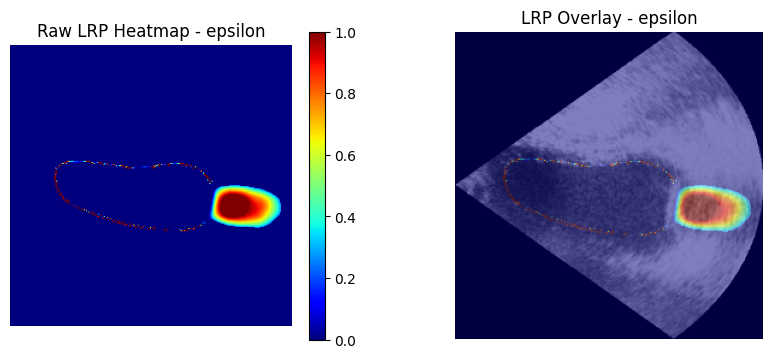


=== LRP Rule: z-plus ===
Relevance stats: min = 0.0 max = 291.7060241699219 mean = 0.16780075430870056


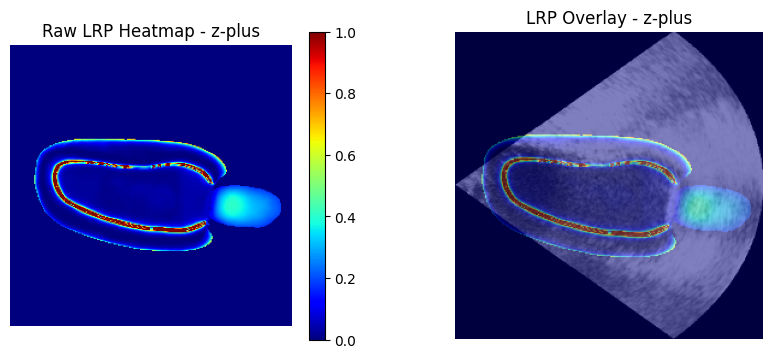


=== LRP Rule: gamma ===
Relevance stats: min = 0.0 max = 854.3428344726562 mean = 0.23417261242866516


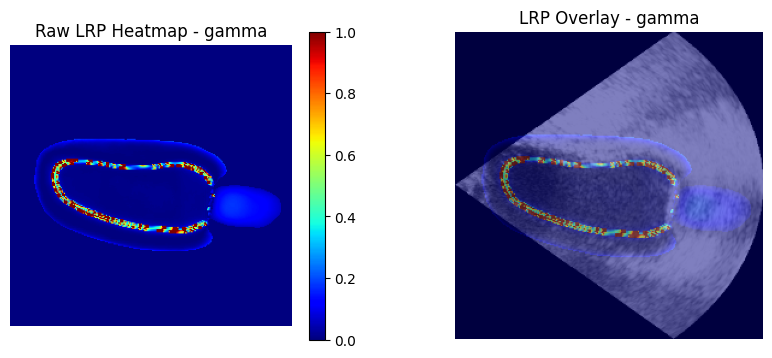


=== LRP Rule: alpha-beta ===
Relevance stats: min = 0.0 max = 257.677490234375 mean = 0.3081967532634735


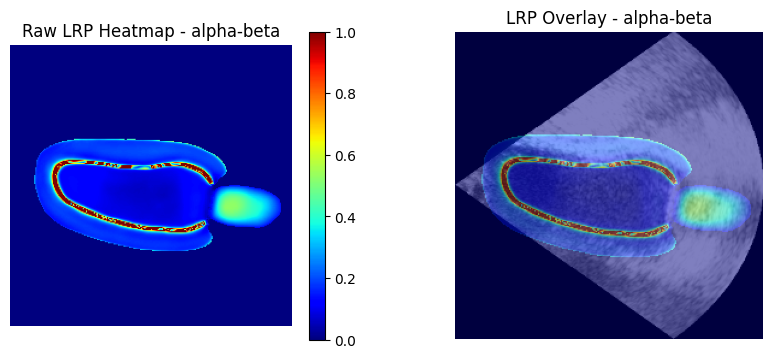


=== LRP Rule: flat ===
Relevance stats: min = -0.4918818473815918 max = 0.0 mean = -0.12352587282657623


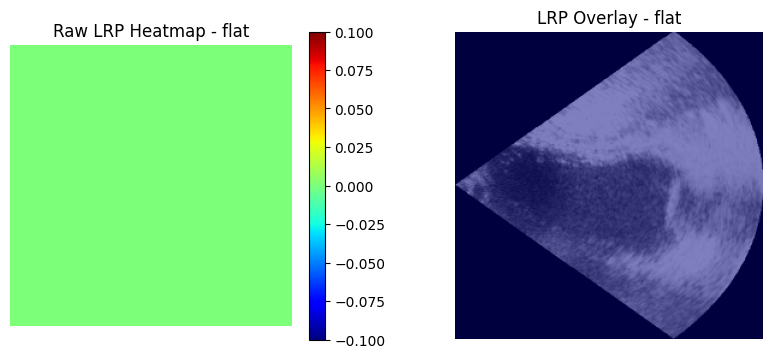


=== LRP Rule: w-squared ===
Relevance stats: min = -3.086409568786621 max = 5.900312900543213 mean = 0.5408759117126465


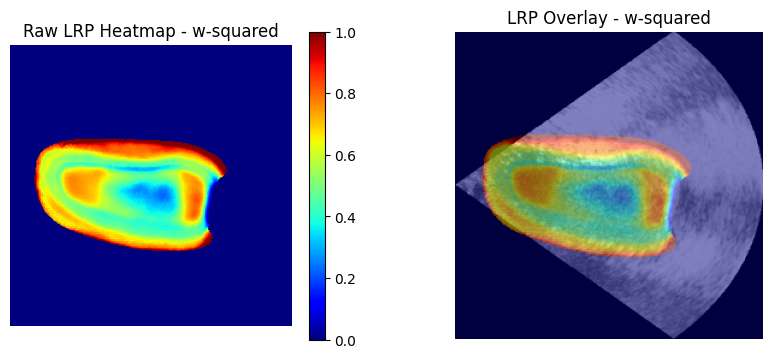


=== LRP Rule: zB ===
Relevance stats: min = -187.7501678466797 max = 240.22142028808594 mean = -0.380302369594574


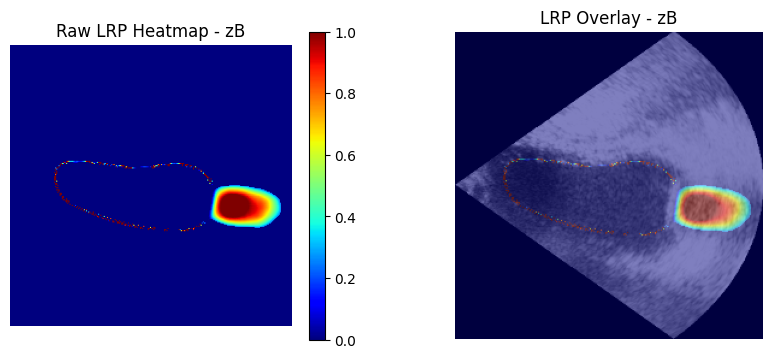

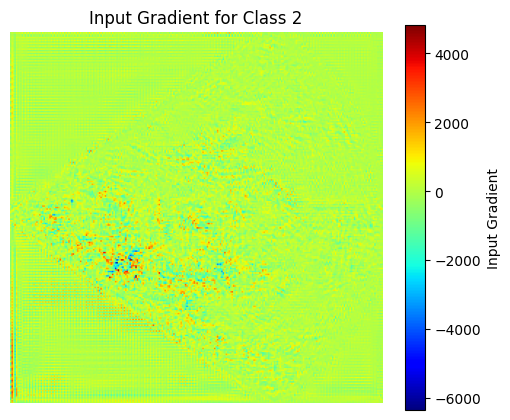

In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import cv2  # For image resizing
import segmentation_models_pytorch as smp

# ----------------------------
# Helper Function to Load .nii.gz Image
# ----------------------------
def load_nii_image(image_path, target_size=(256, 256)):
    """
    Loads a 2D .nii.gz image, normalizes it, resizes it,
    and converts it to a torch tensor of shape [1, 1, H, W].
    
    Parameters:
        image_path (str): Path to the .nii.gz image.
        target_size (tuple): Desired output size as (width, height).
    
    Returns:
        torch.Tensor: The processed image tensor.
    """
    nii = nib.load(image_path)
    img_data = nii.get_fdata()
    
    # If the image is 3D, handle singleton dimensions or choose the middle slice.
    if img_data.ndim == 3:
        if img_data.shape[2] == 1:
            img_data = np.squeeze(img_data, axis=2)
        else:
            slice_index = img_data.shape[2] // 2
            img_data = img_data[:, :, slice_index]
    
    # Normalize to [0, 1]
    img_min, img_max = img_data.min(), img_data.max()
    if img_max - img_min > 0:
        img_data = (img_data - img_min) / (img_max - img_min)
    else:
        img_data = img_data - img_min
        
    # Resize using cv2 (target_size provided as (width, height))
    new_W, new_H = target_size
    resized = cv2.resize(img_data.astype(np.float32), (new_W, new_H))
    
    # Add channel dimension for a single-channel image: [1, H, W]
    resized = np.expand_dims(resized, axis=0)
    # Add batch dimension: [1, 1, H, W]
    resized = np.expand_dims(resized, axis=0)
    
    return torch.tensor(resized, dtype=torch.float32)

# ----------------------------
# Main Function
# ----------------------------
def main():
    # 1. Setup & Model Loading
    model_path = r"/home/sailesh/Desktop/Rohit/models/efficientn_best_nii.pth"
    image_path = r"/home/sailesh/Desktop/Rohit/dataset/nii_img/patient0001_2CH_ED.nii.gz"
    
    # Define UNet Model with EfficientNet-B3 Encoder
    model = smp.Unet(
        encoder_name="efficientnet-b3",
        encoder_weights="imagenet",
        in_channels=1,
        classes=3,  # Three foreground classes
        activation=None  # No activation; BCEWithLogitsLoss applies sigmoid
    )
    
    model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
    model.eval()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Load image (shape: [1, 1, H, W])
    image = load_nii_image(image_path, target_size=(256, 256)).to(device)
    image.requires_grad = True
    
    # ---- Modified Forward Pass ----
    # Instead of calling model(image) directly, we manually call the encoder,
    # decoder, and then the segmentation head.
    encoder_features = model.encoder(image)
    decoder_output = model.decoder(*encoder_features)
    output = model.segmentation_head(decoder_output)  # Final output: [1, 3, H, W]
    # ---------------------------------
    
    segmentation_output = torch.sigmoid(output)
    
    print("Segmentation output stats:",
          "min =", segmentation_output.min().item(),
          "max =", segmentation_output.max().item(),
          "mean =", segmentation_output.mean().item())
    
    # Convert the original image for visualization.
    # Replicate the single channel to form an RGB image.
    orig_img_np = image[0, 0].detach().cpu().numpy()  # [H, W]
    orig_img_np = np.stack([orig_img_np]*3, axis=-1)     # [H, W, 3]
    orig_img_np = np.clip(orig_img_np, 0, 1)
    
    # 2. Visualize Segmentation Mask Overlay
    # (Assumes overlay_seg_mask_on_image is defined elsewhere)
    seg_mask = (segmentation_output.mean(dim=1, keepdim=True) > 0.3).float()
    seg_mask_np = seg_mask[0, 0].detach().cpu().numpy()
    overlaid_seg = overlay_seg_mask_on_image(orig_img_np, seg_mask_np, alpha=0.3, mask_color=(1, 0, 0))
    
    plt.figure()
    plt.imshow(overlaid_seg)
    plt.title("Segmentation Mask Overlaid on Original")
    plt.axis("off")
    plt.show()
    
    # 3. Run Each LRP Rule and Visualize Results (applied only to the final output layer)
    class_idx = 2  # Choose the output channel (class) to analyze

    # Extract the final convolution layer from the segmentation head.
    # (Assuming model.segmentation_head is a Sequential and its first element is a Conv2d)
    final_conv = model.segmentation_head[0]

    for rule_name, lrp_fn in lrp_functions.items():
        print(f"\n=== LRP Rule: {rule_name} ===")
        # Create a clone of the final output and extract relevance for the specified class
        relevance = output.detach().clone()  # [B, 3, H, W]
        relevance = lrp_class_specific(relevance, class_idx)  # [B, 1, H, W]
        
        # Apply LRP to the final output layer.
        # Pass the activation that goes into the final convolution (decoder_output) as input.
        if rule_name == "flat":
            relevance = lrp_fn(final_conv, decoder_output, relevance, seg_mask=seg_mask)
        else:
            relevance = lrp_fn(final_conv, decoder_output, relevance)
        
        # If multiple channels exist, average them.
        if relevance.shape[1] > 1:
            relevance = relevance.mean(dim=1, keepdim=True)
        
        # Optionally apply the segmentation mask to the relevance.
        relevance = apply_segmentation_mask(relevance, seg_mask, threshold=0.3)
        print("Relevance stats:", 
              "min =", relevance.min().item(),
              "max =", relevance.max().item(),
              "mean =", relevance.mean().item())
        
        # Normalize and prepare the heatmap.
        heatmap = relevance.detach().squeeze().cpu().numpy()
        p99 = np.percentile(heatmap, 99)
        heatmap = np.clip(heatmap, 0, p99)
        hm_min, hm_max = heatmap.min(), heatmap.max()
        if hm_max > hm_min:
            heatmap = (heatmap - hm_min) / (hm_max - hm_min)
        else:
            heatmap = np.zeros_like(heatmap)
        
        overlaid_hm = overlay_heatmap_on_image(orig_img_np, heatmap, alpha=0.5, cmap='jet')
        
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(heatmap, cmap='jet')
        plt.colorbar()
        plt.title(f"Raw LRP Heatmap - {rule_name}")
        plt.axis("off")
        
        plt.subplot(1, 2, 2)
        plt.imshow(overlaid_hm)
        plt.title(f"LRP Overlay - {rule_name}")
        plt.axis("off")
        plt.show()
    
    # 4. (Optional) Visualize Input Gradient
    model.zero_grad()
    output[0, class_idx].sum().backward(retain_graph=True)
    grad = image.grad.data[0, 0].cpu().numpy()
    
    plt.figure(figsize=(6, 5))
    plt.imshow(grad, cmap='jet')
    plt.colorbar(label="Input Gradient")
    plt.title(f"Input Gradient for Class {class_idx}")
    plt.axis("off")
    plt.show()
    
if __name__ == "__main__":
    main()